$$
\newcommand{\bm}{\boldsymbol}
\newcommand{\Pr}{\mathbb{P}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\T}{\top}
\DeclareMathOperator{\Var}{Var}
\DeclareMathOperator{\Cov}{Cov}
\DeclareMathOperator*{\argmax}{argmax}
\DeclareMathOperator*{\argmin}{argmin}
$$

In [35]:
# number the equations (TeX/MathJax)
# display("text/html", "<script type=\"text/javascript\">MathJax.Hub.Config({ TeX: { equationNumbers: { autoNumber : \"AMS\" }} })</script>")

In [36]:
# Install some packages
# plotting (Gadfly and Compose)
using Pkg 
Pkg.add("Gadfly")
Pkg.add("Compose")
# optimization
Pkg.add("NLopt")

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [37]:
using Gadfly
using Compose
set_default_plot_size(12cm, 12cm)

Needed later, can ignore for now

In [38]:
# an update in place operator
function arrow(a, b)
    for f in fieldnames(typeof(a))
        setfield!(a, f, getfield(b, f))
    end
end

arrow (generic function with 1 method)

# Gaussian processes with Julia

The aim of this session is to introduce Gaussian process regression, and show how it might be implemented in Julia.  I haven't considered Gaussian process classification (but see the Resources section).

Currently, Julia is gradually settling on its core language feature set and syntax, so expect some breaking changes until Julia v1.0.  This notebook was written for Julia v0.6.

Although this isn't a language tutorial, I have tried to explain some of the less-obvious semantics and features.

- https://julialang.org/
- https://docs.julialang.org/en/stable/
- https://github.com/JuliaLang/julia


## Introduction and Notation

Suppose we have some data

$$
\begin{equation}
\{(\bm{x}^{(i)}, t^{(i)})\}_{i=1}^N
\end{equation}
$$

where $\bm{x}^{(i)}$ is the _i_-th (vector) _input_ and $t^{(i)}$ is the corresponding (scalar) _observation_.  It is often convenient to write $\bm{X} = (\bm{x}^{(i)})_{i=1}^N$ and $\bm{t} = (t^{(i)})_{i=1}^N$.

We wish to construct a model so that given a new input $\bm{x}'$ we can make a prediction of the corresponding $t'$.  That is to say, we wish to find the posterior probability distribution of $t'$, given $\bm{x}'$ and the other observations:

$$
\begin{equation}
\Pr(t' \mid \bm{x}', \{(\bm{x}^{(i)}, t^{(i)})\}_{i=1}^N) \equiv \Pr(t' \mid \bm{x}', \bm{X}, \bm{t}). \qquad (\star)
\label{eq:cond-distr}
\end{equation}
$$

This is just the familiar problem of function fitting or regression.

The conditional distribution, $(\star)$, can be expressed straightforwardly in terms of the joint distribution,

$$
\begin{equation}
\Pr(t' \mid \bm{x}', \bm{X}, \bm{t}) = \frac{\Pr(\bm{t},t'\mid \bm{X},\bm{x}')}{\Pr(\bm{t} \mid \bm{X})}. \qquad (\clubsuit)
\label{eq:cond-distr2}
\end{equation}
$$

Supposing that the $t^{(i)}$ are drawn from a _Gaussian process_ (defined in the next section) allows us to evaluate the right-hand side of this expression exactly.  We will see that this is equivalent to inferring a functional model for our data (perhaps with noise), with a particular prior on the space of functions.

## Gaussian processes

A **Gaussian process** is a stochastic process $(t^{(n)})_{n \in I}$, with $n$ ranging over an index set $I$, where any finite collection of variables $\bm{t} = (t^{(n_1)}, t^{(n_2)}, \ldots, t^{(n_N)})$ has a joint Gaussian distribution:

$$
\begin{gather}
\Pr(\bm{t}\mid \bm\mu, \bm{C}) = \frac{1}{Z} \exp \left( -\half (\bm{t} - \bm\mu )^\T \bm{C}^{-1} (\bm{t} - \bm\mu ) \right)\\
Z = \left. 1 \middle/ \sqrt{(2\pi)^N\det{C}}. \right.
\end{gather}
$$

The $\bm{C}$ in this equation is unspecified, and we will see that a central problem for a modelling task is to choose it well.  We will most often have $\bm\mu = \bm{0}$.  The components of $\bm{C}$ are usually functions of the input coordinates $\bm{X}$.  Once we know how to calculate $\bm{C}$, we can compute the quantity appearing on the RHS of equation $(\clubsuit)$.  We show how this is done in **Making predictions**.

### Simple example

To illustrate the idea, we consider a simple example with two variables, one a known input and one to predict.

Suppose these are $t_1$ and $t_2$, and as above, we know that they have a joint Gaussian distribution.  Suppose also that we know that these have $\bm\mu = \bm{0}$ and a given covariance matrix $\bm C$ shown below.

In this scenario, if we know the value of $t_1$, we can compute the conditional distribution of the unknown $t_2$.  Relating this to the previous section, $t_1$ plays the role of the known observations ($\bm{t}$), and $t_2$ is the output we wish to infer ($t'$).

Since we specify $\bm{C}$ directly, we do not consider the $\bm{x}$s in this example, although $\bm{C}$ would normally be computed in terms of them.

In [39]:
using LinearAlgebra

In [40]:
C = [1.00 0.95;
     0.95 1.00]

2×2 Array{Float64,2}:
 1.0   0.95
 0.95  1.0 

The following defines the pdf of a joint Gaussian in two variables, with a given covariance matrix.

In [41]:
# Julia features: import, named parameters, matrix division, unpacking

"Pdf of a joint Gaussian distribution in two variables."
function gaussian_pdf(x,y; cov_matrix=C)
    # the \ operator is linear system solve (similar to Matlab).
    return exp(-0.5*dot([x,y],cov_matrix\[x,y])) / (2*pi) * sqrt(det(cov_matrix))
end

gaussian_pdf

We can define a conditional distribution as follows.

In [42]:
# quadgk: numerical integration in 1-d
import QuadGK: quadgk

"""
    conditional_distr(f :: Function, condition :: Function)

Given a distribution `f`, representing a pdf ``f_{X,Y}(x,y)``, and a 
condition `condition` of the form `y -> (a,y)`, returns a function of
one argument representing ``f_{Y|X=a}(y)``.  Limited to two variables 
due to quadgk.
"""
function conditional_distr(f, condition)
    marginal, error = quadgk(x -> f(condition(x)...), -Inf, Inf)
    return (x -> f(condition(x)...)/marginal)
end

conditional_distr

The string just before the function declaration is an optional docstring.  Documentation can be accessed in the REPL and in a Jupyter notebook with `?`

In [43]:
?conditional_distr

search: conditional_distr



```
conditional_distr(f :: Function, condition :: Function)
```

Given a distribution `f`, representing a pdf $f_{X,Y}(x,y)$, and a  condition `condition` of the form `y -> (a,y)`, returns a function of one argument representing $f_{Y|X=a}(y)$.  Limited to two variables  due to quadgk.


Below we plot the joint density, and the conditional distribution with our known $t_0 = 1$.  This is done using [Gadfly.jl](http://gadflyjl.org/stable/index.html), a plotting library inspired by "The Grammar of Graphics" and ggplot2.

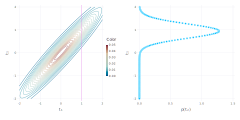

(Gadfly.Coord.Cartesian(Symbol[:x, :xmin, :xmax, :xintercept], Symbol[:y, :ymin, :ymax, :yintercept, :middle, :lower_hinge, :upper_hinge, :lower_fence, :upper_fence, :outliers], -2.0, 2.0, -2.0, 2.0, false, false, false, nothing, false), nothing)

In [44]:
# Julia features: let, plotting with Gadfly

plot_range = 0.

let t1s = range(-2.0,stop=2.0,length=200)
    t2s = range(-2.0,stop=2.0,length=200)
    plot_range = Coord.cartesian(xmin=minimum(t1s),
                                 xmax=maximum(t1s),
                                 ymin=minimum(t2s),
                                 ymax=maximum(t2s)),

    
    draw(SVGJS(24cm, 12cm),
         hstack(plot(x = t1s,
                     y = t2s,
                     z = [gaussian_pdf(t1,t2) for t1 in t1s, t2 in t2s],
                     plot_range,
                     Geom.contour(levels=20),
                     Guide.annotation(compose(context(), # new empty context for the composed annotation
                            line([(1.0,10.0), (1.0,-10.0)]),
                            stroke("violet"))),
                     Guide.xlabel("t₁"),
                     Guide.ylabel("t₂")),
                plot(x = [conditional_distr(gaussian_pdf, y->(1,y))(t1) for t1 in t1s],
                     y = t1s,
                     Guide.xlabel("p(t₂)"), 
                     Guide.ylabel("t₂"))))
end

The right-hand plot gives the predictive distribution of $t_2$, given $t_1$, based on the covariance matrix above.  This is just another Gaussian of course, with

$$
t_2 \sim \mathcal{N} \left(\frac{C_{12}}{C_{11}}t_1,\; C_{22} - \frac{C_{12}^2}{C_{11}}\right).
$$

This is preciesly $(\clubsuit)$ in our two variable case.  Making predictions of more than one variable, from more than one input point is just the obvious extension of this idea to more than two variables, as we shall see below.

## Another perspective

Suppose we believe that our observations $t$ arise from sampling from a function $y(\bm{x})$, perhaps with some noise.  We then express our inference problem as that of determining the posterior distribution of the function $y(\bm{x})$ given the observations.  Using Bayes' rule, we get

$$ 
\Pr(y(\bm{x}) \mid \bm{t}, \bm{X}) = 
\frac{\Pr(\bm{t} \mid y(\bm{x}), \bm{X})\Pr(y(\bm{x}))}{\Pr(\bm{t}\mid\bm{X})}.
$$

The first term in the numerator of the RHS represents the noise, which is often taken to be a separable multivariate Gaussian distribution.

The second term in the numerator is the prior distribution of functions in our model.  We could specify a prior by first parameterizing $y$, but Gaussian processes allow us to put a prior directly on the space of functions.  This is done by stating that function evaluations form a Gaussian process, and by specifying the covariance for the underlying function for pairs of inputs, that is, we specify a $k$ such that

$$
\Cov(y(\bm{x}^{(1)}),y(\bm{x}^{(2)})) = k(\bm{x}^{(1)},\bm{x}^{(2)}).
$$

We must clearly be careful what we mean by statements like "putting a prior on the space of functions".  This perspective can be formulated rigorously (which I haven't included here), and the two points of view—distributions of finite samples from a stochastic process and distributions on the function space—connected.  The relevant result is Komolgorov's existance theorem, aka the Daniell-Komolgorov theorem.

## Covariance kernels

As suggested above, the covariance kernel specifies how entries of the covariance matrix $\bm{C}$ are calculated from the input coordinates.  In addition, the covariance matrix must incorporate the noise model.  We will exclusively use parameter-independent Gaussian noise, giving a covariance matrix with entries

$$
C_{ij} = k(\bm{x}^{(i)}, \bm{x}^{(j)}) + \nu\delta_{ij}.
$$

A very common choice of covariance kernel is the squared exponential, which is simply

$$
k_{\text{sqexp}}(\bm{x}^{(1)},\bm{x}^{(2)}) = \sigma^2\exp\left(-\half\sum_i \frac{(x^{(1)}_i - x^{(2)}_i)^2}{r_i^2} \right),
$$
or in Julia:

In [45]:
squared_exp(x,y,σ,r) = σ^2 * exp(-sum(0.5*(x-y).^2/r.^2))

squared_exp (generic function with 1 method)

This expresses the idea that function values are more correlated when their arguments are close, and become rapidly decorrelated past a certain characteristic distance for each component, $r_i$.

A careful choice of kernel can capture other known properties of the function, such as periodicity.

The covariance matrix is required to be symmetric and non-negative definite.

If the covariance function depends only on the separation ($\bm{x} - \bm{y}$), then it is said to be *stationary*, although this is not a requirement.


## Making predictions

Given our $N$ observations $\{(\bm{x}^{(i)}, t^{(i)})\}_{i=1}^N$, a covariance kernel $k$ and a noise hyperparameter $\nu$, and suppose that we want to make a prediction at a new point $\bm{x}'$, which we call $t'$.

To make this prediction, first compute the covariance matrix for all $N+1$ input coordinates, $\bm{C}_{N+1}$, and then the conditional distribution is

$$
\Pr(t'\mid \bm{t}, \bm{X}, \bm{x}') = \frac{1}{Z} \exp \left( -\half \left[\bm{t}\; t'\right]\bm{C}_{N+1}^{-1}
\begin{bmatrix}\bm{t}\\ t'\end{bmatrix} \right).
$$

In principle, we are now done, since the mean and variance of this (single variable) Gaussian distribution characterize the predictive distribution entirely.  It is possible however to evaluate $\bm{C}_{N+1}$ analytically in terms of $\bm{C}_N$, the covariance matrix of just the training data.

Using the notation from MacKay, an additional observation corresponds to adding an additional row and column to the covariance matrix:

$$
\begin{equation}
\bm{C}_{N+1} = 
\begin{bmatrix}
    \begin{bmatrix}
        & & \\
        & \bm{C}_N & \\
        & &
    \end{bmatrix}  &  
    \!\!\!\begin{bmatrix}
        \\
        \bm{k} \\
        {}
    \end{bmatrix} \\
    \begin{bmatrix}
        \, & \bm{k}^\T & \,
    \end{bmatrix} &
    \!\!\!\begin{bmatrix}
        \,\kappa\,
    \end{bmatrix}
\end{bmatrix}
\end{equation}.
$$

The inverse of this block matrix can be computed directly using the identity given below, and for this case it turns out that

$$
\newcommand{\m}{\mathscr{m}}
\bm{C}_{N+1}^{-1} =
\left[\!\!
\begin{array}{c|c}
    \bm{M} & \bm{m} \\
    \hline
    \bm{m} & \m
\end{array}
\!\!\right]
$$

where

$$
\begin{align}
\newcommand{\Ci}{\bm{C}_N^{-1}}
\mathscr{m} &= \left(\kappa - \bm{k}^\T\Ci\bm{k}\right)^{-1}\\
\bm{m} &= -\m \Ci\\
\bm{M} &= \Ci + \frac{1}{\m}\bm{m}\bm{m}^\T.
\end{align}
$$

This allows the predictive mean and variance to be read off as

$$
\boxed{
\begin{align}
\bar{t}' &= \bm{k}^\T\Ci\bm{t}\\
\Var(t') &= \kappa - \bm{k}^\T\Ci\bm{k}.
\end{align}
}
$$

We can obtain a similar expression for the case of multiple dependent predictions, see the section **Sampling from the process**.

### Matrix identity

We used the following identity for the inverse of a block-partitioned matrix:

$$
\newcommand{\A}{\bm{A}}
\newcommand{\B}{\bm{B}}
\newcommand{\C}{\bm{C}}
\newcommand{\D}{\bm{D}}
\newcommand{\inv}[1]{#1^{-1}}
\left[\!\!
\begin{array}{c|c}
    \bm{A} & \bm{B} \\
    \hline
    \bm{C} & \bm{D}
\end{array}
\!\!\right]^{-1} =
\left[\!\!
\begin{array}{c|c}
    \inv{(\A-\B\inv\D\C)} & -\inv{(\A - \B\inv\D\C)}\B\inv\D \\
    \hline
    -\inv\D\C\inv{(\A - \B\inv\D\C)} & \inv\D + \inv\D\C\inv{(\A-\B\inv\D\C)}\B\inv\D
\end{array}
\!\!\right]
$$

## Cost

- **Training** is somewhat better than $O(N^3)$ multiplications, from inverting $\bm{C}_N$.
- **Predictive mean** calculation from an already-trained process is $O(N)$ (a single dot-product of two length-$N$ vectors)
- **predictive variance** calculation is $O(N^2)$.

## Representing Gaussian Processes

Now let us define a type representing a Gaussian process.

In [46]:
mutable struct GP
    # The covariance function
    cov_kernel :: Function
    # The noise model
    ν          :: Float64
    # The hyperparameters
    θ          :: Vector{Float64}
    # The inputs and observations
    xs         :: Vector
    ts         :: Vector{Float64}
    # Covariance matrix (and its inverse)
    C          :: Matrix{Float64}
    # Inverse of covariance matrix (but see note)
    invC       :: Matrix{Float64}
    # Precomputed C\ts
    invCts     :: Vector{Float64}
end

Define a constructor for the GP struct

In [47]:
function GP(cov_kernel, ν, θ, xs=Array{Float64,1}(undef, 0), ts=Array{Float64,1}(undef, 0))
    # compute the covariance matrix
    C = [cov_kernel(x1, x2, θ...) for x1=xs, x2=xs] + Diagonal([ν for x=xs])
    # defer to the default constructor
    GP(cov_kernel, ν, θ, xs, ts, C, inv(C), C \ ts)
end

GP

A GP object can now be constructed like this:

In [48]:
my_gp = GP(squared_exp, 1E-7, [4.0, 20.0], [1.0, 2.0, 3.0], [1.0, 2.0, 3.0])

GP(squared_exp, 1.0e-7, [4.0, 20.0], [1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [16.0 15.98 15.9202; 15.98 16.0 15.98; 15.9202 15.98 16.0], [5003.77 -9982.53 4991.24; -9982.53 19940.2 -9982.53; 4991.24 -9982.53 5003.77], [12.4408, -49.7567, 37.5033])

To do something interesting with it, we define some methods on it.

In [49]:
covar(gp :: GP, x1, x2) = gp.cov_kernel(x1, x2, gp.θ...)


# Julia feature: M' == transpose(M)
function gp_predict(gp :: GP, xnew :: Float64)
    k = [covar(gp, xnew, x) for x = gp.xs]
    kappa = covar(gp, xnew, xnew) + gp.ν
    mean = k' * gp.invCts
    var = kappa - k' * gp.invC * k
    return (mean, var)
end

"""Given a Gaussian process and a vector of input vectors to predict, 
return a tuple consisting of the mean and covariance of the posterior 
distribution at those points"""
function gp_predict(gp :: GP, xnews :: Vector)
    k = [covar(gp, xnew, x) for x = gp.xs, xnew = xnews]
    kappa = [covar(gp, xnew1, xnew2) for xnew1 in xnews, xnew2 in xnews] + Diagonal([gp.ν for xnew in xnews])
    means = k' * gp.invCts
    vars = kappa - k' * gp.invC * k
    return (means, vars)
end

"Update the hyperparameters in place"
function set_hyperparameters!(gp :: GP, hypers :: Vector{Float64})
    if (gp.ν != hypers[1]) || (gp.θ != hypers[2:end])
        # We defined 'arrow' above: performs the update in place
        arrow(gp, GP(gp.cov_kernel, hypers[1], hypers[2:end], gp.xs, gp.ts))
    end
end

set_hyperparameters!

### Defining some synthetic data

In [50]:
# Julia features: DataFrames, anonymous functions, random numbers

using DataFrames

let xs = range(0.0,stop=1.0,length=11)
    global synth1 = DataFrame(x = xs, 
                              t = map(x -> x + 0.1*randn(), xs))
end

let xs = range(0.0,stop=1.0,length=21);
    global synth2 = DataFrame(x = xs,
                              t = map(x -> sin(7*x) + 0.5*sin(9*x) + 1.2*sin(11*x), xs))
end

synth3 = DataFrame(x = [1,2,3,4,5], t = [1.2, 2.0, 0.0, 4.0, 5.0])

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


5×2 DataFrame
│ Row │ x     │ t       │
│     │ Int64 │ Float64 │
├─────┼───────┼─────────┤
│ 1   │ 1     │ 1.2     │
│ 2   │ 2     │ 2.0     │
│ 3   │ 3     │ 0.0     │
│ 4   │ 4     │ 4.0     │
│ 5   │ 5     │ 5.0     │

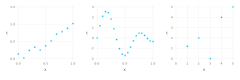

In [51]:
# Julia features: symbols, quoting
draw(SVGJS(24cm, 8cm),
    hstack(plot(synth1, x=:x, y=:t), plot(synth2, x=:x, y=:t), plot(synth3, x=:x, y=:t)))

### Predictive distributions on some of the synthetic data

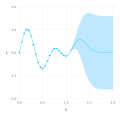

In [52]:
# Julia features: convert, ribbon plots from a DataFrame

synth2_gp = GP(squared_exp, 1E-6, [4.0, 0.2], convert(Array, synth2[:x]), convert(Array, synth2[:t]))
begin
    xs = range(0.0,stop=2.0,length=100)
    ts_it, vars_it = zip([gp_predict(synth2_gp, x) for x in xs]...)
    ts = [ts_it...]
    vars = [vars_it...]
    global synth2_fit = DataFrame(
                x = xs,
                t = ts,
                tmin = ts - sqrt.(vars),
                tmax = ts + sqrt.(vars)
           )
end
plot(layer(synth2, x=:x, y=:t, Geom.point),
     layer(synth2_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon))

Notice that far away from the data, the posterior process tends to the mean ($0$) and standard deviation ($\sigma = 4$) of the prior process.

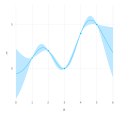

In [53]:
synth3_gp = GP(squared_exp, 1E-6, [4.0, 1.0], convert(Array, synth3[:x]), convert(Array, synth3[:t]))
begin
    xs = range(0.0,stop=6.0,length=100)
    ts_it, vars_it = zip([gp_predict(synth3_gp, x) for x in xs]...)
    ts = [ts_it...]
    vars = [vars_it...]
    global synth3_fit = DataFrame(
                x = xs,
                t = ts,
                tmin = ts - sqrt.(vars),
                tmax = ts + sqrt.(vars)
           )
end
plot(layer(synth3, x=:x, y=:t, Geom.point),
     layer(synth3_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon),  Coord.cartesian(ymax=7))

## Sampling from the process

Let $\bm{t}^*$ be a sample of $m$ elements from the Gaussian process that we wish to take, with inputs $\bm{x}^{*(i)}$ $(1\le i \le m)$.

Sampling a vector from the Gaussian process prior is just sampling from the multivariate normal distribution with covariance corresponding to the sample inputs $\bm{x}^{*(i)}$:

$$
\begin{gather}
\bm{t}^* \sim N(\bm{0},\bm{\kappa})\\
\kappa_{ij} = k(\bm{x}^{*(i)}, \bm{x}^{*(j)}) + \nu\delta_{ij}.
\end{gather}
$$

Sampling from the posterior distribution uses the predictive distribution above, resulting in

$$
\bm{t}^* \sim N\left(\bm{K}^\T \bm{C}^{-1}\bm{t},\; \bm\kappa-\bm{K}^\T \bm{C}^{-1} \bm{K}\right)
$$

where $\bm{t}$ and $\bm{C}$ are the observations and their covariances, $\bm\kappa$ is the same expression as above, $K_{ij} = k(\bm{x}^{(i)},\bm{x}^{*(j)})$ is an $n\times m$ matrix ($n$ initial observations, and $m$ in the sample).

In [54]:
# Julia has many built in distributions - MvNormal is a multivariate normal
import Distributions: MvNormal

# rand draws samples from the given distribution, with optional argument of the count
rand(MvNormal([0.0,0.0], [1.0 0.0; 0.0 1.0]), 5)

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


2×5 Array{Float64,2}:
 -0.29203   -1.1745    1.23667  -0.804568   0.697986
 -0.404825  -0.233897  1.34892   0.367703  -0.729798

### Sampling from the Prior

In [55]:
function gp_sample_prior(gp :: GP, xs, count=1)
    vars = [covar(gp, x1, x2) for x1 in xs, x2 in xs] + Diagonal([gp.ν for x in xs])
    rand(MvNormal(zero(xs), vars), count)
end

gp_sample_prior (generic function with 2 methods)

Let's sample from the GP prior we defined above, with $\nu = 10^{-6}$, $\sigma^2 = 4.0$ and $r = 1.0$.

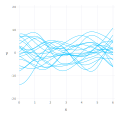

In [56]:
let xs = range(0.0,stop=6.0,length=100)
    plot([layer(y = gp_sample_prior(synth3_gp, xs), x=xs, Geom.line) for i in 1:20]...)
end

This time, let's sample from the prior process with $\nu = 1.0$, $\sigma^2 = 4.0$ and $r = 5.0$.

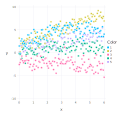

In [57]:
let xs = range(0.0,stop=6.0,length=100)
    plot([layer(y = gp_sample_prior(GP(squared_exp, 1.0, [4.0, 5.0]), xs), 
                x = xs, 
                Geom.point, 
                color = [i]) 
          for i in 1:5]..., Scale.color_discrete())
end

### Sampling from the Posterior

In [58]:
# Sample from a given Gaussian process at a vector of xs
function gp_sample(gp :: GP, xs, count=1)
    ts, vars = gp_predict(gp, xs)
    vars = 0.5 * (vars + vars')
    
    rand(MvNormal(ts, vars), count)
end

gp_sample (generic function with 2 methods)

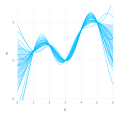

In [59]:
let xs = range(0.0,stop=6.0,length=100)
    plot([layer(y = gp_sample(synth3_gp, Vector(xs)), x=xs, Geom.line) for i in 1:20]...,
        layer(synth3_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon),
        Coord.cartesian(ymin = -5.0, ymax = 7.0))
end

If we use the other choice of hyperparameters above, the posterior is

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
  [442fdcdd] + Measures v0.3.0
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


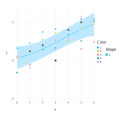

In [66]:
using Measures
synth3_gp2 = GP(squared_exp, 1.0, [4.0, 5.0], convert(Array, synth3[:x]), convert(Array, synth3[:t]))
begin
    xs = range(0.0,stop=6.0,length=100)
    ts_it, vars_it = zip([gp_predict(synth3_gp2, x) for x in xs]...)
    ts = [ts_it...]
    vars = [vars_it...]
    global synth3_fit = DataFrame(
                x = xs,
                t = ts,
                tmin = ts - sqrt.(vars),
                tmax = ts + sqrt.(vars)
           )
end

let xs = range(0.0,stop=6.0,length=7)
    plot(layer(synth3, x=:x, y=:t, Geom.point, Theme(default_color="black", point_size=Measures.Length{:mm,Float64}(1.3)), shape=[Shape.xcross]),
        [layer(y = gp_sample(synth3_gp2, Vector(xs)), x=xs, Geom.point, color=[i]) for i in 1:5]...,
        layer(synth3_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon),
        Coord.cartesian(ymin = -5.0, ymax = 7.0), Scale.color_discrete())
end

## Optimizing the hyperparameters

So far we have fixed a set of hyperparameters and made predictions from these.  As the number of training points increases, the hyperparameters become less significant for prediction, but this is not that useful in most cases.

Instead of choosing a single value of the hyperparameters, which are usually unknown, it is better to marginalize over them.  That is, to compute

$$
\begin{equation}
\Pr(t' \mid \bm{x}', \bm{X}, \bm{t}) = \int_\Theta \Pr(t' \mid \bm{x}', \bm{X}, \bm{t}, \Theta) \, \Pr(\Theta \mid \bm{X}, \bm{t}) \; \text{d}\Theta.
\end{equation}
$$

This could be computed using Monte Carlo integration (see the DSS session on MCMC), but often this integral is dominated by the most likely value of $\Theta$:

$$
\begin{gather}
\Pr(t' \mid \bm{x}', \bm{X}, \bm{t}) \approx \Pr(t' \mid \bm{x}', \bm{X}, \bm{t}, \Theta_{\text{MP}})\\
\Theta_{\text{MP}} = \argmax_\Theta \Pr(\Theta \mid \bm{X}, \bm{t}).
\end{gather}
$$

The posterior probability of $\Theta$ is
$$
\begin{equation}
\Pr(\Theta \mid \bm{X}, \bm{t}) \propto \Pr(\bm{t} \mid \bm{X}, \Theta)\,\Pr(\Theta).
\end{equation}
$$

It is usually most convenient to work with the logarithm of the liklihood.  The logarithm of the first term on the RHS is

$$
\log \Pr(\bm{t} \mid \bm{X}, \Theta) = -\half \log\det \bm{C} - \half \bm{t}^\T \bm{C}^{-1} \bm{t} - \frac{N}{2} \log{2\pi}.
$$

We can maximize this using an algorithm of our choice.  An analytic expression for the gradient is reasonably straightforward, or automatic differentiation could be used, but below I will use a derivative-free optimization method for simplicity, at the cost of slower convergence.

In [61]:
# Numerical note: logdet computes the logarithm of the determinant directly and stably
function log_lik(gp::GP)
    -0.5 * (log(det(gp.C)) + gp.ts' * gp.invC * gp.ts)[1]
end

log_lik (generic function with 1 method)

In [62]:
"Wrapper function around `log_lik` to pass to the optimizer."
function log_lik!(gp::GP, hypers::Vector, grad::Vector = []; verbose::Bool = false)
    set_hyperparameters!(gp, hypers)

    ll = log_lik(gp)
    
    strify(vec) = chomp(string(vec'))
    if verbose
        print("log_lik! : ν=$(hypers[1])\t θ=$(strify(hypers[2:end]))\t log(likelihood)=$ll\n")
    end
    
    return ll
end

log_lik!

The function that actually performs the optimization.  Uses the [NLopt library](https://nlopt.readthedocs.io/en/latest/).

In [63]:
using NLopt

function log_lik_optim!(gp::GP, lbounds, ubounds; iterations=20, ftol_rel=1e-2)
    f(hypers, grad_unused) = log_lik!(gp, hypers, grad_unused, verbose=true)
    opt = Opt(:LN_BOBYQA, length(gp.ν) + length(gp.θ))
    max_objective!(opt, f)
    lower_bounds!(opt, lbounds)
    upper_bounds!(opt, ubounds)
    ftol_rel!(opt, ftol_rel)
    maxeval!(opt, iterations)
    (maxf, maxx, ret) = optimize(opt, vcat(gp.ν, gp.θ))
end

log_lik_optim! (generic function with 1 method)

Optimize the hyperparameters of our 'synth3' example

In [64]:
# Make a copy since log_lik! modifies its argument
let synth3_gp_optim = deepcopy(synth3_gp)
    log_lik_optim!(synth3_gp_optim, [1.0e-9, 1.0, 0.1], [1.0, 5.0, 10.0], iterations=20, ftol_rel=1E-5)
end

log_lik! : ν=1.0e-6	 θ=[4.0 1.0]	 log(likelihood)=-7.384171100135093
log_lik! : ν=1.7492499999999998e-6	 θ=[4.0 1.0]	 log(likelihood)=-7.384171105407588
log_lik! : ν=1.0e-6	 θ=[5.0 1.0]	 log(likelihood)=-7.906435562849556
log_lik! : ν=1.0e-6	 θ=[4.0 1.675]	 log(likelihood)=-30.611521695968488
log_lik! : ν=2.507500000000001e-7	 θ=[4.0 1.0]	 log(likelihood)=-7.3841710948627775
log_lik! : ν=1.0e-6	 θ=[3.0 1.0]	 log(likelihood)=-7.227912494724456
log_lik! : ν=1.0e-6	 θ=[4.0 0.325]	 log(likelihood)=-8.370452843913647
log_lik! : ν=9.999999998368534e-7	 θ=[3.0011 0.689993]	 log(likelihood)=-7.334770008990914
log_lik! : ν=9.25075e-7	 θ=[2.9 1.0]	 log(likelihood)=-7.264002035078898
log_lik! : ν=1.0228697731042894e-6	 θ=[3.1523 0.867775]	 log(likelihood)=-7.098133037575252
log_lik! : ν=1.174348552375832e-6	 θ=[3.00576 0.859435]	 log(likelihood)=-7.07456530682477
log_lik! : ν=1.163327307862098e-6	 θ=[3.06861 0.91099]	 log(likelihood)=-7.073562866796451
log_lik! : ν=1.1345504055900113e-6	 θ=[2.976

(-7.061620100068389, [1.03231e-6, 2.93823, 0.885044], :MAXEVAL_REACHED)

This reproduces Figure 45.2(c) in MacKay's book.

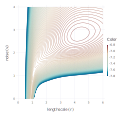

In [65]:
let synth3_gp_plot = deepcopy(synth3_gp)
    σ = 2.94 # the value for σ found in the optimization above, which is fixed for the plot
    plot(z=(x,y)->log_lik!(synth3_gp_plot, [y, σ, x]; verbose=false), 
         y=range(0.0,stop=4.0,length=100), 
         x=range(0.0,stop=6.0,length=100), 
         Geom.contour(levels=[range(-7.8,stop=-6.8,length=100)...]),
         Coord.cartesian(xmin = 0.0, xmax = 6.0,
                         ymin = 0.0, ymax = 4.0),
         Guide.xlabel("lengthscale (r)"),
         Guide.ylabel("noise (ν)"))
end

There are two local maxima.  One has low noise and is close to the parameters used in the `synth3_gp` example above, and the other has higher noise and is close to `synth3_gp2`.

## Resources

- Much of this was following "Information Theory, Inference and Learning Algorithms" by David MacKay, available online - http://www.inference.org.uk/itprnn/book.html
- Collection of various resources, including a comparison of libraries/software - http://www.gaussianprocess.org
- Accessible online lecture notes on stochastic processes - https://fabricebaudoin.wordpress.com/2012/03/23/introductionbm/
- Existing Julia packages for GPs: there seem to be several, and I haven't tried any of them.  This demonstration could have begun `Pkg.add("GaussianProcesses")`...

## Other topics

- Heteroskedacity
- Reduced-rank GPs
- Co-kriging
- Many simpler models can be formulated as GPs, including linear regression, spline fitting and a certain class of neural network.  See Ch 45 in MacKay for these examples.